# Introduction

This notebook has the purpose of analyzing macroeconomical data about countries. Specifically, it tries to model the GDP per capita of a country given its exportations, political stability and regulation quality.

This exercise has the only purpose to serve as a way to prove the skills of the author using common machine learning models and data science tools in Python.

All the data was extracted from the world bank's database, and corresponds of yearly measurements of the variables mentioned before.

Here, after importing the data, it passes through a data cleansing step, where unnecessary columns are drop and, given the small amount of data available in the temporal dimension, the countries with NaN values in some years are dropped from the data frames. Despite not being optimal in small datasets, rows with NaN values are dropped directly because of the high propensity of the entries with values in those rows to be distorted.

After the cleansing step, a transformation step is performed, since some data has very different scales. Then an exploratory step to determine how much correlated the data is, and to search for possible outliers.

Finally, some machine learning models will be used to fit the data, and will be evaluated to determine the one how better explains GDP per capita of a given country. Also, some hypotheses will be checked to verify the the expected statistical properties of the models.

## Cleansing step

We first begin by importing some packages and dropping the columns that will not be used.

In [1]:
import os
import numpy as np
import pandas as pd

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
# Define file names
file_dir="World Bank Data"
exports_file="Exports of goods and services (Current USD).csv"
gdp_file="GDP per capita (Current USD).csv"
pol_stab_file="Political Stability and Absence of Violence.csv"
reg_quality_file="Regulatory Quality.csv"

# Import Data as Pandas DataFrames and Drop unnecessary columns
df_Exports=pd.read_csv(os.path.abspath(file_dir+'/'+exports_file),usecols=[2,3]+list(range(6,16)),skiprows=range(267,272), na_values='..')
df_GDP=pd.read_csv(os.path.abspath(file_dir+'/'+gdp_file),usecols=[0,1]+list(range(4,2021-1960+5)),skiprows=range(4), na_values='..')
df_Pol_Stab=pd.read_csv(os.path.abspath(file_dir+'/'+pol_stab_file),usecols=[0,1]+list(range(4,14)),skiprows=range(215,220), na_values='..')
df_Reg_Quality=pd.read_csv(os.path.abspath(file_dir+'/'+reg_quality_file),usecols=[0,1]+list(range(4,14)),skiprows=range(215,220), na_values='..')

# Rename columns
for year in np.arange(2012, 2022):
    key = "{0} [YR{0}]".format(year)
    df_Exports.rename(columns={key: year}, inplace=True)
    df_Pol_Stab.rename(columns={key: year}, inplace=True)
    df_Reg_Quality.rename(columns={key: year}, inplace=True)
for year in np.arange(1960, 2022):
    df_GDP.rename(columns={str(year): year}, inplace=True)

# Sort countries alphabetically
df_Exports.sort_values(by=["Country Code"], inplace=True, ignore_index=True)
df_GDP.sort_values(by=["Country Code"], inplace=True, ignore_index=True)
df_Pol_Stab.sort_values(by=["Country Code"], inplace=True, ignore_index=True)
df_Reg_Quality.sort_values(by=["Country Code"], inplace=True, ignore_index=True)

# Drop unncesessary columns
df_Exports.drop(columns="Country Name", inplace=True)
df_GDP.drop(columns="Country Name", inplace=True)
df_Pol_Stab.drop(columns="Country Name", inplace=True)
df_Reg_Quality.drop(columns="Country Name", inplace=True)

Now, we inspect the data using the head and describe methods.

In [3]:
df_Exports.head()

,Country Code,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,ABW,1.911732e+09,2.088268e+09,2.184358e+09,2.158659e+09,2.143017e+09,2.243575e+09,2.363128e+09,2.460174e+09,1.347955e+09,2.154232e+09
1,AFE,2.884747e+11,2.848333e+11,2.767795e+11,2.121727e+11,1.903936e+11,2.202650e+11,2.531566e+11,2.367578e+11,2.041730e+11,2.779762e+11
2,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFW,2.503025e+11,1.963233e+11,2.078493e+11,1.334840e+11,1.165598e+11,1.423347e+11,1.709977e+11,1.725504e+11,1.240349e+11,1.657901e+11
4,AGO,6.992416e+10,6.769742e+10,6.134144e+10,2.595175e+10,1.401738e+10,2.000493e+10,3.176775e+10,2.827171e+10,1.911095e+10,2.984373e+10


In [4]:
df_Exports.describe()

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,2.320000e+02,2.340000e+02,2.350000e+02,2.350000e+02,2.340000e+02,2.360000e+02,2.330000e+02,2.300000e+02,2.260000e+02,2.110000e+02
mean,8.064051e+11,8.194129e+11,8.281643e+11,7.337647e+11,7.210599e+11,7.925551e+11,8.834944e+11,8.811638e+11,8.130252e+11,1.074920e+12
std,2.574707e+12,2.639419e+12,2.686576e+12,2.404613e+12,2.371459e+12,2.600114e+12,2.863526e+12,2.833551e+12,2.598195e+12,3.318403e+12
min,2.642555e+07,2.212087e+07,2.409924e+07,2.673661e+07,3.430969e+07,2.954414e+07,2.113486e+07,3.250977e+07,2.301727e+07,2.629207e+07
25%,3.942057e+09,3.772556e+09,3.917787e+09,3.305320e+09,3.412079e+09,3.665407e+09,4.503669e+09,4.601104e+09,3.460658e+09,5.841577e+09
50%,3.209082e+10,3.240108e+10,2.991609e+10,2.294857e+10,2.183075e+10,2.201281e+10,3.037729e+10,2.990024e+10,2.517934e+10,4.485022e+10
75%,3.372622e+11,3.149119e+11,3.096840e+11,2.601310e+11,2.353360e+11,2.744587e+11,3.172899e+11,3.229071e+11,2.865568e+11,3.753391e+11
max,2.292249e+13,2.351095e+13,2.389675e+13,2.128080e+13,2.088040e+13,2.301872e+13,2.521591e+13,2.479112e+13,2.245058e+13,2.787684e+13


In [5]:
df_GDP.head()

,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25609.955724,26515.678080,26942.307976,28421.386493,28451.273745,29326.708058,30220.594523,31650.760537,24487.863560,29342.100858
1,AFE,162.907576,162.546236,171.996697,199.182564,179.381788,198.223726,209.407648,211.699966,224.232269,...,1760.216229,1731.795976,1719.809190,1540.850354,1432.111827,1613.788555,1550.180567,1500.229274,1353.769160,1537.336021
2,AFG,62.369375,62.443703,60.950364,82.021738,85.511073,105.243196,143.103233,167.165675,134.012768,...,663.141053,651.987862,628.146804,592.476537,520.252064,530.149831,502.056771,500.522664,516.866552,368.754614
3,AFW,106.976475,112.047561,117.730633,122.278715,130.599963,137.186142,142.895375,127.303606,128.365494,...,1953.407033,2149.295219,2243.271464,1876.623483,1645.023767,1585.911930,1731.311792,1749.303317,1683.436391,1757.030626
4,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4962.552072,5101.983876,5059.080441,3100.830685,1709.515534,2283.214233,2487.500996,2142.238757,1603.993477,1953.533757


In [6]:
df_GDP.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,133.000000,135.000000,137.000000,137.000000,137.000000,148.000000,151.000000,155.000000,160.000000,160.000000,...,258.000000,259.000000,260.000000,258.000000,257.000000,257.000000,257.000000,255.000000,252.000000,245.000000
mean,476.232844,489.201568,513.139254,544.597889,590.847870,651.586693,706.996587,718.836652,735.268656,796.464280,...,16248.504224,16769.079112,17083.391999,15423.812801,15582.336416,16382.944242,17343.981739,17230.949757,15773.341770,16881.223038
std,613.928195,636.644849,667.981641,707.491580,774.016468,851.791530,923.715887,954.842175,983.005166,1060.071744,...,23881.993666,25382.942943,25945.885695,23375.307394,23586.328634,24397.928346,25978.879159,25792.183787,24065.845038,26114.316956
min,40.119192,26.318449,26.983496,28.434172,20.018579,16.577652,12.786964,12.900238,20.395642,20.682296,...,238.205949,241.547671,257.818552,289.359633,242.065671,243.135809,231.446477,216.972968,216.826741,221.477676
25%,106.976475,111.389614,115.074813,122.278715,123.606837,141.578148,145.758775,152.410537,149.457032,151.663406,...,1986.934959,2110.418190,2173.282618,2097.331179,2079.448266,2088.500117,2269.177012,2186.046582,2139.636129,2304.844567
50%,218.259153,198.934696,207.633534,211.901118,236.941713,252.273023,267.334103,252.252422,292.642193,293.802194,...,6454.612266,6755.073675,6904.579092,6192.562429,6079.088736,6436.791746,6912.110297,6837.717826,6034.203335,6621.574336
75%,476.621422,495.611861,545.119867,587.006885,642.688431,687.197972,769.896013,763.567965,760.566852,826.288906,...,19638.711938,19792.134133,20277.795912,18210.359456,18575.232027,19743.954909,20614.898856,19809.323139,18652.166722,18751.026512
max,3007.123445,3066.562869,3243.843078,3374.515171,3573.941185,4081.915955,4229.254573,4336.426587,4695.923390,5032.144743,...,165505.178100,185066.578133,195780.006893,170337.924413,174610.636972,173612.864622,194280.822141,199377.481832,182538.638340,234315.460504


In [7]:
df_Pol_Stab.head()

,Country Code,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,ABW,1.263882,1.312226,1.164568,1.230921,1.284199,1.335038,1.356553,1.349796,1.390273,1.474335
1,AFG,-2.418561,-2.519349,-2.411068,-2.571222,-2.671054,-2.801084,-2.763864,-2.655531,-2.705030,-2.529855
2,AGO,-0.389323,-0.391233,-0.333232,-0.500898,-0.315899,-0.380449,-0.335692,-0.358525,-0.514615,-0.710836
3,AIA,1.476920,1.533980,1.164255,1.249272,1.315344,1.389452,1.287406,1.355694,1.545165,1.585498
4,ALB,-0.143632,0.091930,0.485986,0.346129,0.344645,0.378475,0.370516,0.111169,0.087552,0.109446


In [8]:
df_Pol_Stab.describe()

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,2.120000e+02,2.120000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.130000e+02,2.130000e+02,2.130000e+02,2.130000e+02
mean,1.702319e-11,-4.101993e-10,1.582366e-09,5.517314e-10,6.234566e-10,9.875968e-11,2.141386e-09,-3.825856e-09,-2.570975e-09,1.196946e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.860755e+00,-2.758687e+00,-2.748824e+00,-2.974081e+00,-2.916323e+00,-2.942443e+00,-3.005906e+00,-2.770830e+00,-2.708138e+00,-2.683239e+00
25%,-6.409787e-01,-6.382599e-01,-6.062841e-01,-6.130840e-01,-5.812653e-01,-6.238537e-01,-6.058792e-01,-5.735922e-01,-6.020207e-01,-6.119987e-01
50%,1.123929e-01,1.020356e-01,8.109321e-02,6.997049e-02,1.401536e-01,8.809575e-02,6.508543e-02,6.423968e-02,9.297203e-02,1.249118e-01
75%,8.982176e-01,8.963631e-01,8.164504e-01,8.746988e-01,8.705758e-01,8.180234e-01,8.462771e-01,8.092755e-01,8.658568e-01,8.558095e-01
max,1.934407e+00,1.931953e+00,1.924541e+00,1.943138e+00,1.965062e+00,1.923353e+00,1.929881e+00,1.883894e+00,1.909082e+00,1.884071e+00


In [9]:
df_Reg_Quality.head()

,Country Code,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,ABW,1.402131,1.420880,1.245361,1.366900,1.344240,1.189792,0.854681,0.855567,0.925701,0.946877
1,AFG,-1.192580,-1.193090,-1.124134,-1.006208,-1.336582,-1.355373,-1.147590,-1.123046,-1.402761,-1.338022
2,AGO,-0.990438,-1.041670,-0.860683,-0.842345,-0.957893,-1.026228,-0.785790,-0.820472,-0.841778,-0.662632
3,AIA,1.321213,1.319419,0.880748,0.908654,0.867860,0.839894,0.821928,0.844434,0.942807,0.955577
4,ALB,0.240492,0.254160,0.279038,0.189515,0.196169,0.233087,0.266459,0.285659,0.235865,0.192754


In [10]:
df_Reg_Quality.describe()

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,2.120000e+02,2.120000e+02,2.090000e+02,2.090000e+02,2.090000e+02,2.090000e+02,2.090000e+02,2.090000e+02,2.090000e+02,2.090000e+02
mean,1.150974e-09,1.203690e-09,-2.767231e-09,-2.067625e-09,4.653967e-09,2.227789e-12,-1.305634e-09,4.149734e-10,1.829224e-09,2.562251e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.526690e+00,-2.522705e+00,-2.186970e+00,-2.327977e+00,-2.337121e+00,-2.342525e+00,-2.366042e+00,-2.399907e+00,-2.351887e+00,-2.327385e+00
25%,-7.527374e-01,-7.423129e-01,-8.205630e-01,-7.892590e-01,-7.388666e-01,-7.329381e-01,-7.265729e-01,-7.113730e-01,-7.503176e-01,-7.455136e-01
50%,-1.099980e-01,-7.784022e-02,-4.767074e-02,-8.145170e-02,-1.199808e-01,-6.401664e-02,-7.728238e-02,-5.046416e-02,-3.500562e-02,-7.314753e-02
75%,8.022217e-01,7.837789e-01,7.479463e-01,7.656437e-01,7.187521e-01,7.020710e-01,7.128169e-01,8.444337e-01,7.945549e-01,8.316994e-01
max,1.957902e+00,1.960108e+00,2.226360e+00,2.255347e+00,2.177773e+00,2.161466e+00,2.225087e+00,2.160113e+00,2.212867e+00,2.231044e+00


As you can see, the GDP dataframe has way more timestamps than the other dataframes. We will discard the extra columns because we can't use them jointly with the other dataframes.

In [11]:
# Drop years not used in GDP
df_GDP_clean = df_GDP.drop(columns=list(np.arange(1960, 2012))).copy()

Also, as you can see, there are some rows with missing values. In fact, there are rows with all its data missing. We proceed by dropping the mentioned rows.

In [12]:
df_GDP_clean.dropna(inplace=True)
df_Exports.dropna(inplace=True)
df_Pol_Stab.dropna(inplace=True)
df_Reg_Quality.dropna(inplace=True)

Now we'll drop all the countries that aren't in all the dataframes.

In [13]:
countries = df_GDP_clean.merge(df_Exports, how="inner", on="Country Code", suffixes=("x0", "x1")).merge(df_Pol_Stab, how="inner", on="Country Code", suffixes=("x2", "x3")).merge(df_Reg_Quality, how="inner", on="Country Code", suffixes=("x4", "x5"))["Country Code"]
df_GDP_clean = df_GDP_clean[df_GDP_clean["Country Code"].isin(countries)]
df_Exports = df_Exports[df_Exports["Country Code"].isin(countries)]
df_Pol_Stab = df_Pol_Stab[df_Pol_Stab["Country Code"].isin(countries)]
df_Reg_Quality = df_Reg_Quality[df_Reg_Quality["Country Code"].isin(countries)]
df_GDP_clean.head()

,Country Code,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,ABW,25609.955724,26515.678080,26942.307976,28421.386493,28451.273745,29326.708058,30220.594523,31650.760537,24487.863560,29342.100858
4,AGO,4962.552072,5101.983876,5059.080441,3100.830685,1709.515534,2283.214233,2487.500996,2142.238757,1603.993477,1953.533757
5,ALB,4247.630047,4413.062005,4578.633208,3952.802538,4124.055390,4531.019374,5287.663694,5396.215864,5332.160475,6492.872012
9,ARG,13082.664326,13080.254732,12334.798245,13789.060425,12790.242473,14613.041825,11795.159387,9963.672506,8496.424142,10636.120196
10,ARM,3643.715183,3833.157532,4017.229808,3666.141876,3679.951972,4041.995021,4391.923697,4828.505178,4505.867364,4966.513471


# Data Exploration and Transformation

Now that we have our dataframes cleansed, we will proceed to explore and transform the data. Note that in the exports' dataframe, when using the describe method, we get that the value of the first quartile is about 100 times lower than the third quartile. Something similar seems to happen to GDP per capita.

Because of the above, we apply a log transformation to these dataframes to get data on similar scales.

In [14]:
df_GDP_clean[np.arange(2012, 2022)] = np.log(df_GDP_clean[np.arange(2012, 2022)])
df_GDP_clean.describe()

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,8.754390,8.790602,8.804945,8.711182,8.710808,8.770001,8.822862,8.819718,8.748683,8.864027
std,1.441706,1.437957,1.430436,1.409653,1.414958,1.420342,1.428731,1.424181,1.413226,1.428523
min,5.473136,5.487067,5.552256,5.667670,5.489209,5.493620,5.444349,5.379773,5.379099,5.400322
25%,7.662831,7.742118,7.746069,7.711586,7.675749,7.680285,7.744008,7.702009,7.690726,7.777629
50%,8.702269,8.736449,8.747481,8.639158,8.633178,8.693072,8.728343,8.722593,8.627650,8.732328
75%,9.882578,9.896377,9.911847,9.782551,9.785667,9.837491,9.896203,9.880322,9.880434,10.031166
max,11.631461,11.695248,11.725442,11.566106,11.579642,11.624651,11.668103,11.662665,11.673091,11.802532


In [15]:
df_Exports[np.arange(2012, 2022)] = np.log(df_Exports[np.arange(2012, 2022)])
df_Exports.describe()

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,23.507211,23.542372,23.541953,23.398580,23.390967,23.504080,23.599454,23.613932,23.402636,23.630211
std,2.412226,2.404330,2.413594,2.398839,2.379628,2.391962,2.415880,2.368821,2.447780,2.485288
min,17.089842,16.912032,16.997691,17.101544,17.350938,17.201396,16.866434,17.297051,16.951756,17.084778
25%,21.917336,21.936795,21.938426,21.867641,21.922220,21.964370,22.164040,22.183753,21.906909,22.128967
50%,23.367658,23.415730,23.419921,23.319316,23.357634,23.518282,23.614069,23.619565,23.399510,23.676332
75%,25.286657,25.263110,25.310930,25.121670,25.149439,25.262845,25.351661,25.328025,25.214742,25.384519
max,28.427492,28.487243,28.532336,28.490569,28.433968,28.516523,28.607689,28.597600,28.635276,28.898957


Now it seems much better. In the case of political stability and regulation quality, we note that they are already almost standarized, so we keep them as they are. Now, let's make some plots to search for outliers.

<Axes: >

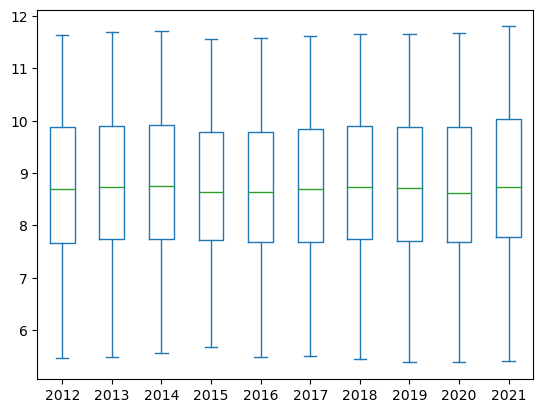

In [16]:
df_GDP_clean.plot(kind="box")

<Axes: >

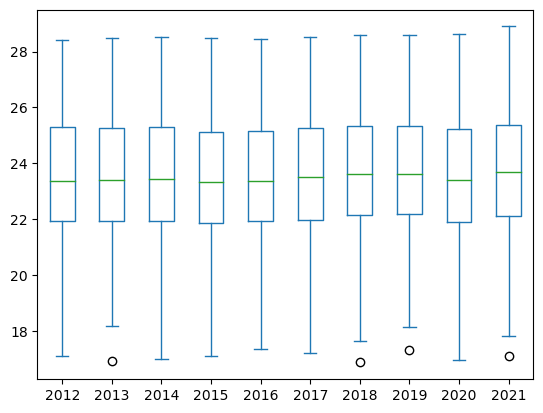

In [17]:
df_Exports.plot(kind="box")

<Axes: >

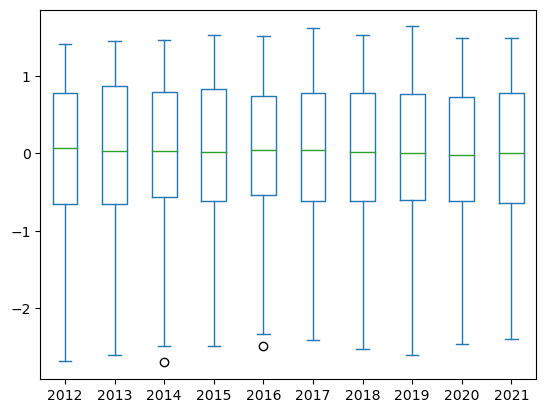

In [18]:
df_Pol_Stab.plot(kind="box")

<Axes: >

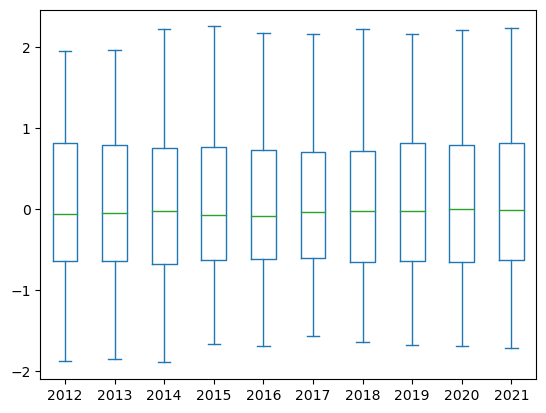

In [19]:
df_Reg_Quality.plot(kind="box")

We identify 4 outliers at the Exportations' boxplot and 2 at political stability. Let's see who they are.

In [20]:
out = list()
out.append(df_Exports[2013].argmin())
out.append(df_Exports[2018].argmin())
out.append(df_Exports[2019].argmin())
out.append(df_Exports[2021].argmin())
out.append(df_Pol_Stab[2014].argmin())
out.append(df_Pol_Stab[2016].argmin())
out

[83, 83, 83, 83, 25, 116]

In [21]:
df_Exports["Country Code"][83]  # Ghana

'GHA'

In [22]:
df_Pol_Stab["Country Code"][25]  # Belize

'BLZ'

In [23]:
df_Pol_Stab["Country Code"][116]  # Luxemburg

'LUX'

So Ghana has some abnormaly low values in exports, and Belize and Luxemburg have an abnormaly low value in political stability. We will dig further on it in the future. At least there is no outlier in the gdp per capita dataframe, which is what we want to study.

We'll pass our dataframes to long format. Since the timestamp is also a variables, we want to set the timestamps in a new column, as well as its respective value. We keep the country's codes as an identifier column.

In [24]:
df_GDP_clean = pd.melt(df_GDP_clean, id_vars="Country Code", value_vars=list(np.arange(2012, 2022)), var_name="Year", value_name="ln(GDP per capita)")
df_Exports = pd.melt(df_Exports, id_vars="Country Code", value_vars=list(np.arange(2012, 2022)), var_name="Year", value_name="ln(Exportations)")
df_Pol_Stab = pd.melt(df_Pol_Stab, id_vars="Country Code", value_vars=list(np.arange(2012, 2022)), var_name="Year", value_name="Political Stability")
df_Reg_Quality = pd.melt(df_Reg_Quality, id_vars="Country Code", value_vars=list(np.arange(2012, 2022)), var_name="Year", value_name="Regulation Quality")
df_GDP_clean.head()

,Country Code,Year,ln(GDP per capita)
0,ABW,2012,10.150736
1,AGO,2012,8.509675
2,ALB,2012,8.354116
3,ARG,2012,9.479043
4,ARM,2012,8.200759


Now that the dataframes are in long format, we'll merge them into a single dataframe.

In [25]:
df = df_GDP_clean.copy()
df["ln(Exportations)"] = df_Exports["ln(Exportations)"]
df["Political Stability"] = df_Pol_Stab["Political Stability"].copy()
df["Regulation Quality"] = df_Reg_Quality["Regulation Quality"].copy()
df.sort_values(by=["Country Code", "Year"], ignore_index=True, inplace=True)
df["Year"] = df["Year"].astype(np.int16)
df.head(13)

,Country Code,Year,ln(GDP per capita),ln(Exportations),Political Stability,Regulation Quality
0,ABW,2012,10.150736,21.371275,1.263882,1.402131
1,ABW,2013,10.185491,21.459601,1.312226,1.420880
2,ABW,2014,10.201453,21.504588,1.164568,1.245361
3,ABW,2015,10.254897,21.492753,1.230921,1.366900
4,ABW,2016,10.255948,21.485480,1.284199,1.344240
5,ABW,2017,10.286254,21.531337,1.335038,1.189792
6,ABW,2018,10.316279,21.583252,1.356553,0.854681
7,ABW,2019,10.362517,21.623498,1.349796,0.855567
8,ABW,2020,10.105933,21.021854,1.390273,0.925701
9,ABW,2021,10.286779,21.490700,1.474335,0.946877


We got a single dataframe with all the data we need. Let's see a bit more of it.

In [26]:
df.shape

(1620, 6)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country Code         1620 non-null   object 
 1   Year                 1620 non-null   int16  
 2   ln(GDP per capita)   1620 non-null   float64
 3   ln(Exportations)     1620 non-null   float64
 4   Political Stability  1620 non-null   float64
 5   Regulation Quality   1620 non-null   float64
dtypes: float64(4), int16(1), object(1)
memory usage: 66.6+ KB


In [28]:
df.describe()

,Year,ln(GDP per capita),ln(Exportations),Political Stability,Regulation Quality
count,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,2016.500000,8.779722,23.513140,-0.018215,0.088940
std,2.873168,1.421831,2.406859,0.919985,0.935160
min,2012.000000,5.379099,16.866434,-2.699193,-1.892658
25%,2014.000000,7.707706,21.962409,-0.618602,-0.645791
50%,2016.500000,8.694113,23.455879,0.030026,-0.029536
75%,2019.000000,9.881144,25.259704,0.785021,0.787928
max,2021.000000,11.802532,28.898957,1.639301,2.255347


<Axes: >

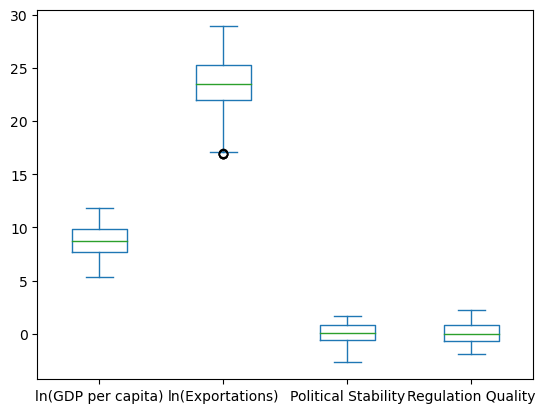

In [29]:
df.iloc[:,2:].plot(kind="box")

In general the data seems pretty good. we have a total of 1620 instances and there are a few (global) outliers at the exportations data.

With all this work, it's time to split the dataframe into a train set and a test set (we'll use the train set for validation). The data will be shuffled to delete any dependence between instances. We'll also use this opportunity to make some plots on the training data.

<Axes: xlabel='ln(GDP per capita)', ylabel='ln(Exportations)'>

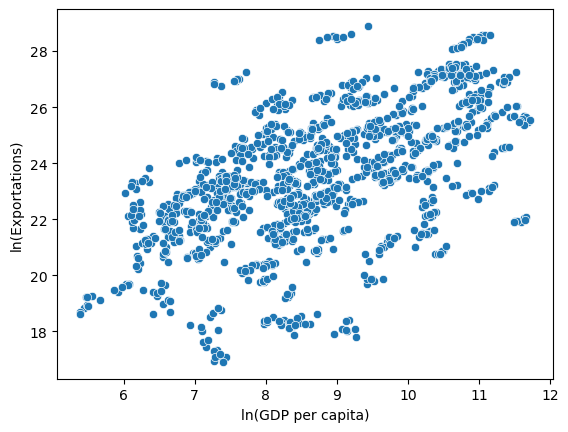

In [30]:
test_size= 0.2
train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, shuffle=True)
sns.scatterplot(data=train_df, x="ln(GDP per capita)", y="ln(Exportations)")

<Axes: xlabel='ln(GDP per capita)', ylabel='Political Stability'>

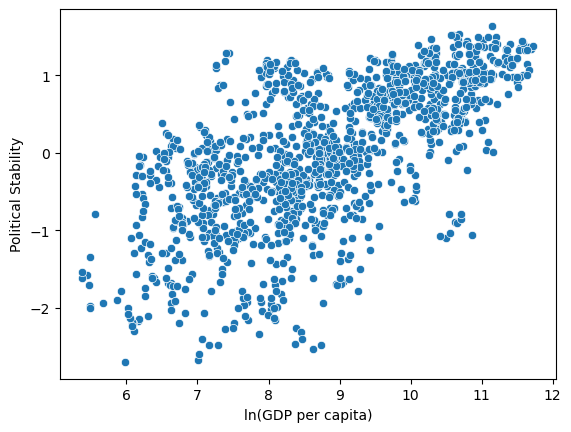

In [31]:
sns.scatterplot(data=train_df, x="ln(GDP per capita)", y="Political Stability")

<Axes: xlabel='ln(GDP per capita)', ylabel='Regulation Quality'>

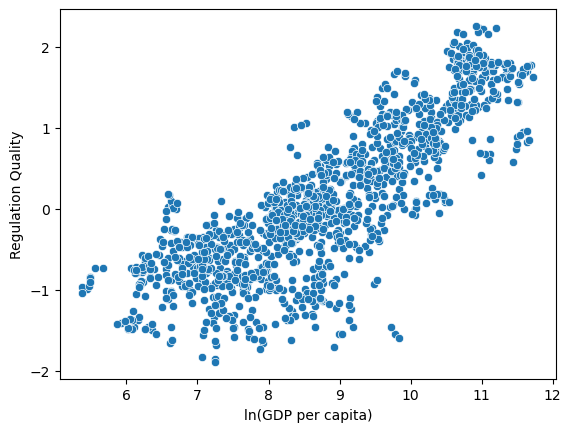

In [32]:
sns.scatterplot(data=train_df, x="ln(GDP per capita)", y="Regulation Quality")

<Axes: >

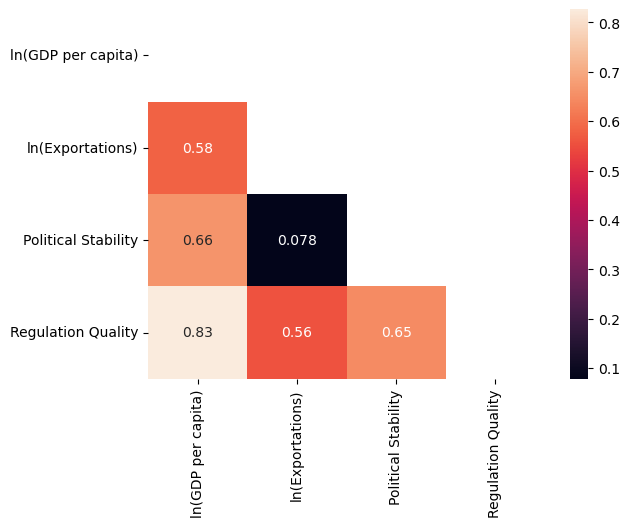

In [33]:
corr = train_df.iloc[:, 2:].corr()
sns.heatmap(corr, annot=True, mask=np.triu(np.ones(corr.shape)))

In [34]:
train_target = train_df.pop("ln(GDP per capita)")
test_target = test_df.pop("ln(GDP per capita)")
train_df.head()

,Country Code,Year,ln(Exportations),Political Stability,Regulation Quality
570,GIN,2012,21.651900,-1.287012,-1.019625
427,DOM,2019,23.744574,0.005307,-0.006671
1087,NGA,2019,24.877871,-1.920183,-0.925424
1329,SGP,2021,27.321465,1.493190,2.231044
398,CZE,2020,25.871087,0.922096,1.244385


In [35]:
train_target.head()

570      6.562398
427      9.008633
1087     7.698112
1329    11.195389
398     10.042940
Name: ln(GDP per capita), dtype: float64

The plots show that the behaviour of the variables with respect of ln(GDP per capita) is not clear, except with Regulation Quality, which seems to behave roughly linearly with respect of ln(GDP per capita).

Note that Regulation Quality is highly (linearly) correlated with ln(GDP per capita), while the other variables seem to have a decent correlation with it. By other side, Regulation Quality has also a decent correlation with the other variables, while Exportations is almost not correlated with Political Stability.

Since Political Stability and ln(Exportations) are less correlated to ln(GDP per capita), let's see if we can do some feature engineering using these two features. Maybe ln(Exportations) is more relevant at countries with a high political stability?

In [36]:
train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, shuffle=True)
train_df["(Pol Stab)/ln(Exp)"]= train_df["Political Stability"]/train_df["ln(Exportations)"]
train_df.head()

,Country Code,Year,ln(GDP per capita),ln(Exportations),Political Stability,Regulation Quality,(Pol Stab)/ln(Exp)
570,GIN,2012,6.562398,21.651900,-1.287012,-1.019625,-0.059441
427,DOM,2019,9.008633,23.744574,0.005307,-0.006671,0.000224
1087,NGA,2019,7.698112,24.877871,-1.920183,-0.925424,-0.077184
1329,SGP,2021,11.195389,27.321465,1.493190,2.231044,0.054653
398,CZE,2020,10.042940,25.871087,0.922096,1.244385,0.035642


<Axes: >

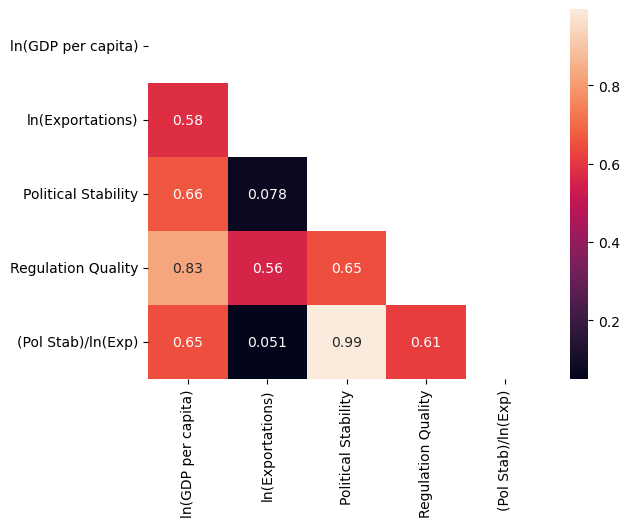

In [37]:
corr = train_df.iloc[:,2:].corr()
sns.heatmap(corr, annot=True, mask=np.triu(np.ones(corr.shape)))

It seems that this new feature is very correlated to Plitical Stability, but Political Stability is a bit more correlated to ln(GDP per capita). Because of that, we will drop the new feature and keep political stability.

In [38]:
train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, shuffle=True)
train_target = train_df.pop("ln(GDP per capita)")
test_target = test_df.pop("ln(GDP per capita)")

Before we proceed further, we'll save the new dataframe to a .csv file. The dataframe has a size of about 67KB , so we can directly save it to a new file. However, it is not always the case, so we tipically want to encode string data to an integer key to save space, which is what we'll do here.

In [39]:
country_df = pd.DataFrame({"Country Code": countries, "Country ID": np.arange(countries.size)})
country_df["Country ID"] = country_df["Country ID"].astype(np.int16)
country_df.head()

,Country Code,Country ID
0,ABW,0
1,AGO,1
2,ALB,2
3,ARG,3
4,ARM,4


In [40]:
df.replace(dict(country_df.values), inplace=True)
df.rename(columns={"Country Code": "Country ID"}, inplace=True)
df["Country ID"] = df["Country ID"].astype(np.int16)
df.head(12)

,Country ID,Year,ln(GDP per capita),ln(Exportations),Political Stability,Regulation Quality
0,0,2012,10.150736,21.371275,1.263882,1.402131
1,0,2013,10.185491,21.459601,1.312226,1.420880
2,0,2014,10.201453,21.504588,1.164568,1.245361
3,0,2015,10.254897,21.492753,1.230921,1.366900
4,0,2016,10.255948,21.485480,1.284199,1.344240
5,0,2017,10.286254,21.531337,1.335038,1.189792
6,0,2018,10.316279,21.583252,1.356553,0.854681
7,0,2019,10.362517,21.623498,1.349796,0.855567
8,0,2020,10.105933,21.021854,1.390273,0.925701
9,0,2021,10.286779,21.490700,1.474335,0.946877


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country ID           1620 non-null   int16  
 1   Year                 1620 non-null   int16  
 2   ln(GDP per capita)   1620 non-null   float64
 3   ln(Exportations)     1620 non-null   float64
 4   Political Stability  1620 non-null   float64
 5   Regulation Quality   1620 non-null   float64
dtypes: float64(4), int16(2)
memory usage: 57.1 KB


In [42]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 161
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Code  162 non-null    object
 1   Country ID    162 non-null    int16 
dtypes: int16(1), object(1)
memory usage: 2.8+ KB


Note how, even when adding the size of the two dataframes, they occupy less space than the original dataframe.

In [43]:
save_dir="Processed Data"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
#os.path.abspath(file_dir+'/'+exports_file)
country_file_name = "CountryID.csv"
data_file_name = "Data.csv"
country_df.to_csv(os.path.abspath(save_dir+'/'+country_file_name), index=False)
df.to_csv(os.path.abspath(save_dir+'/'+data_file_name), index=False)

This format should save space if we are working with a structured (SQL-like) database, specially if want to scale it in the future.

To finish this section, we'll do a hypothesis test to check if our features have high multicolinearity.

In [44]:
exog_idxs = np.arange(2, 5)
vif = np.zeros(shape=exog_idxs.shape)
for i, exog_idx in enumerate(exog_idxs):
    vif[i] = variance_inflation_factor(train_df.iloc[:, exog_idxs], i)

In [45]:
vif

array([1.04660152, 1.73715792, 1.77672824])

The Variance Inflation Factor's of each feature is way below 5, so we can assume there is no multicolinearity (at least, not enough to be a problem).

# Regression and hypotheses tests

## Linear Regression

First, we'll fit a linear model using the statsmodels package, which comes with a set of statistic tools. We'll begin using a ordinary least squares (OLS) model.

In [46]:
X = train_df.iloc[:, exog_idxs]
X = sm.add_constant(X)  # statsmodels needs the user to add a constant column manually
y = train_target
ols = sm.OLS(y, X).fit()
ols.params

const                  4.124717
ln(Exportations)       0.195907
Political Stability    0.584984
Regulation Quality     0.615101
dtype: float64

In [47]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ln(GDP per capita)   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1450.
Date:                Sat, 08 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:21:58   Log-Likelihood:                -1336.5
No. Observations:                1296   AIC:                             2681.
Df Residuals:                    1292   BIC:                             2702.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.1247      0.249     16.539      0.000       3.635       4.614
ln(Exportations)        0.1959      0.011     18.362      0.000       0.175       0.217
Political Stability     0.5850      0.030     19.349      0.000       0.526       0.644
Regulation Quality      0.6151      0.036     17.193      0.000       0.545       0.685
==============================================================================
Omnibus:                       17.626   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.875
Skew:                           0.223   Prob(JB):                     4.83e-05
Kurtosis:                       3.411   Cond. No.                         315.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model gets a R-squared score of 0.77, which is not bad at all considering the number of features we are working with. Also, the tiny p-value on the F-statistic says us that the model is significant.

The tiny p-values per parameter also shows us that each parameter seems to be significant to the model, so we can't just throw them away.

The low p-value on the Omnibus test indicates to us that the explained variance is significantly greater than the unexplained variance. However, the Jarque-Bera statistic is very large, with a tiny p-value, which means the errors are not normally distributed.

We don't take the Durbin-Watson statistic into consideration, since there is a high chance that our target and our features are very autocorrelated, so this test doesn't give us information.

Let's test the homoscedasticity of the residuals.

In [48]:
ols_residuals = y - ols.predict(X)
ols_residuals.rename("OLS training residuals", inplace=True)
het_white(ols_residuals, X)

(101.51096218937728,
 7.78216061716924e-18,
 12.143090591997337,
 1.4071544798151799e-18)

The second value returned by the white test is its p-value, which is near to 0. Because of that, we can discard the hypothesis of the residuals being homoscedastic.

Let's check the residuals distribution and how they behave with respect of the target.

<Axes: ylabel='Density'>

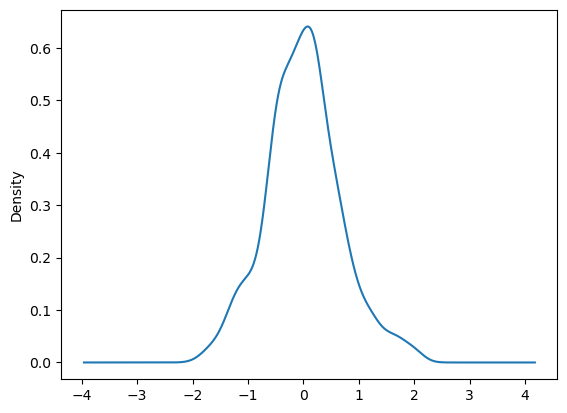

In [49]:
ols_residuals.plot(kind="density")

<Axes: xlabel='ln(GDP per capita)', ylabel='OLS training residuals'>

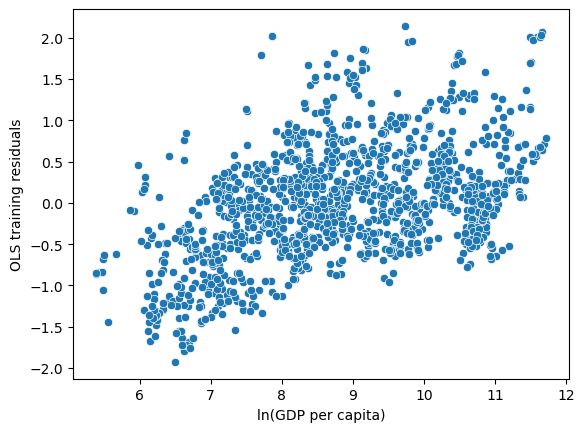

In [50]:
sns.scatterplot(x=train_target, y=ols_residuals)

The residuals distribution seems to be more concentrated at the mean than the normal distribution. Also, the residuals seem to grow with ln(GDP per capita). This last behaviour could be explained by an autocorrelation from the target variable. Since it comes from a time series, that is to be expected.

Let's see, just in case, if there is some leverage point on the dataset.

In [51]:
np.max(OLSInfluence(ols).cooks_distance)

0.9999999999999999

Since the cook's distance for each point is less than 1, we can identify any influential point using these criterion.

In any case, let's see if we can repair the heteroscedasticity of the residuals using another linear regression. Now that we have computed the residuals of the OLS, we can try to fit a Generalized Least Squares (GLS).

In [52]:
gls = sm.GLS(y, X, sigma=np.diag(ols_residuals**2)).fit()
gls.params

const                  4.085593
ln(Exportations)       0.197644
Political Stability    0.584902
Regulation Quality     0.609267
dtype: float64

In [53]:
gls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:     ln(GDP per capita)   R-squared:                       0.998
Model:                            GLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.376e+05
Date:                Sat, 08 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:21:59   Log-Likelihood:                -431.78
No. Observations:                1296   AIC:                             871.6
Df Residuals:                    1292   BIC:                             892.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.0856      0.019    211.936      0.000       4.048       4.123
ln(Exportations)        0.1976      0.001    239.818      0.000       0.196       0.199
Political Stability     0.5849      0.002    305.054      0.000       0.581       0.589
Regulation Quality      0.6093      0.003    204.599      0.000       0.603       0.615
==============================================================================
Omnibus:                     4805.125   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.370
Skew:                           0.021   Prob(JB):                     4.65e-47
Kurtosis:                       1.013   Cond. No.                     1.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that now the model has a R-squared of almost 1, getting similar results for significance, though the residuals are still not normal distributed.

Despite that, at least the residuals should be homoscedastic now.

In [54]:
gls_residuals = y - gls.predict(X)
gls_residuals.rename("GLS training residuals", inplace=True)
het_white(gls_residuals, X)

(100.69220412979395,
 1.1398084430036623e-17,
 12.03689728920815,
 2.126325097353592e-18)

It seems a bit better, but not enough. Let's make some plots again.

<Axes: ylabel='Density'>

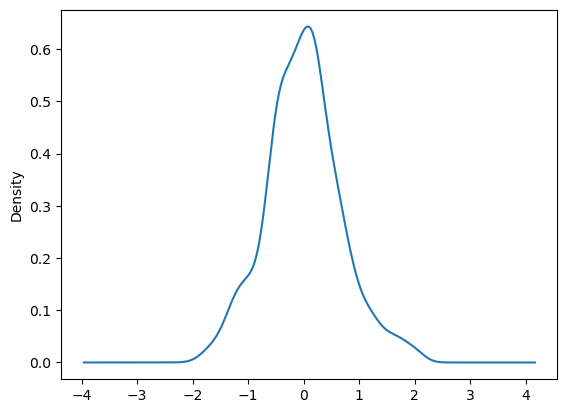

In [55]:
gls_residuals.plot(kind="density")

<Axes: xlabel='ln(GDP per capita)', ylabel='GLS training residuals'>

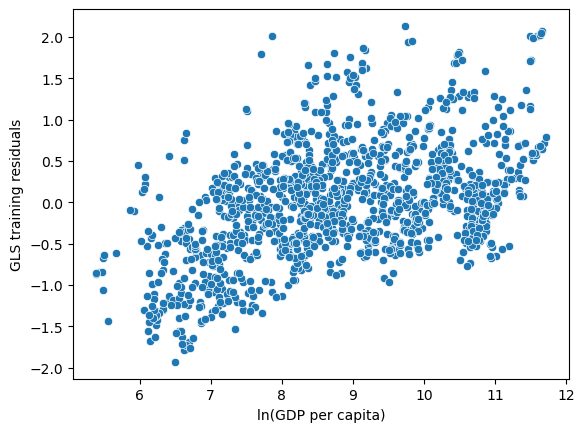

In [56]:
sns.scatterplot(x=train_target, y=gls_residuals)

As expected, nothing changed. As said before, this issues may be produced by the wrong choice of model. We haven't even tested it!. Let's see how the test goes. For testing, we'll compute the Mean Absolute Percentage Error (MAPE) and the determination score on the test data.

In [57]:
X_test = test_df.iloc[:, exog_idxs]
X_test = sm.add_constant(X_test)
y_test = test_target
test_residuals = y_test - gls.predict(exog=X_test)
test_residuals.rename("GLS test residuals", inplace=True)
mape = np.mean(np.abs(test_residuals)/np.abs(y_test))
print("GLS test MAPE =" ,mape)

GLS test MAPE = 0.060328099931684004


In [58]:
ssres = np.sum(test_residuals**2)
sstot = np.sum((y_test-np.mean(y_test))**2)
r2 = 1 - (ssres/sstot)
print("GLS test R2 =", r2)

GLS test R2 = 0.7832581334841864


As expected, the model is greatly overfitted. Let's plot the results. Here we'll use the means over each timestamp to get a cleaner plot.

<Axes: xlabel='Year'>

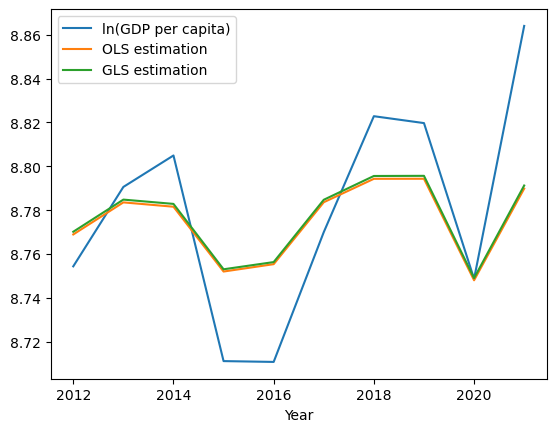

In [59]:
df_grouped = df.groupby(["Year"]).mean()
df_grouped.reset_index(inplace=True)
y = df_grouped.iloc[:, 2]
X = df_grouped.iloc[:, 3:]
X = sm.add_constant(X)
y_ols = ols.predict(X)
y_gls = gls.predict(X)
df_grouped["OLS estimation"] = y_ols
df_grouped["GLS estimation"] = y_gls

fig, ax = plt.subplots()
df_grouped.plot(x="Year", y="ln(GDP per capita)", kind="line", ax=ax)
df_grouped.plot(x="Year", y="OLS estimation", kind="line", ax=ax)
df_grouped.plot(x="Year", y="GLS estimation", kind="line", ax=ax)

Now we will change our focus and inspect an ARIMA-type model.

## Time Series Regression

First, let's see how ln(GDP per capita) behaves with respect of its lags.

<Axes: >

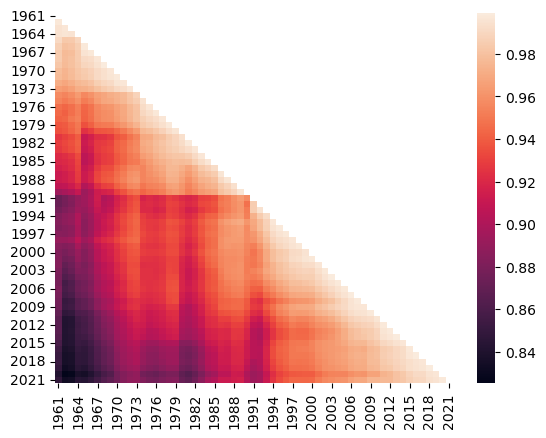

In [60]:
corr = np.log(df_GDP.iloc[:, 2:]).corr()
sns.heatmap(corr, annot=False, mask=np.triu(np.ones(corr.shape)))

As expected, ln(GDP per capita) is highly correlated with its lags, specially with the nearest ones. Beacause of the large amount of time series (we have about 160 of them), we'll simplify the problem by taking the mean of each year. Once we have defined the model, we'll come back and use each series as a test sample.

In [61]:
ts = np.log(df_GDP.iloc[:,1:]).mean()
ts.rename("Mean ln(GDP per capita) Time Series", inplace=True)
ts.index = pd.to_datetime(ts.index, format="%Y")
ts.head()

1960-01-01    5.550075
1961-01-01    5.550298
1962-01-01    5.580718
1963-01-01    5.640358
1964-01-01    5.699261
Name: Mean ln(GDP per capita) Time Series, dtype: float64

<Axes: >

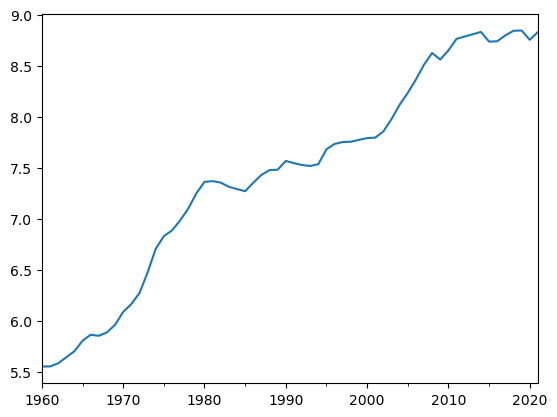

In [62]:
ts.plot(kind='line')

ln(GDP per capita) doesn't seem to have a seasonal component, but seems to be a bit cyclic. We also notice a trend component. In any case, it is not stationary. Now we'll check if we can detrend the time series by differencing.

<Axes: >

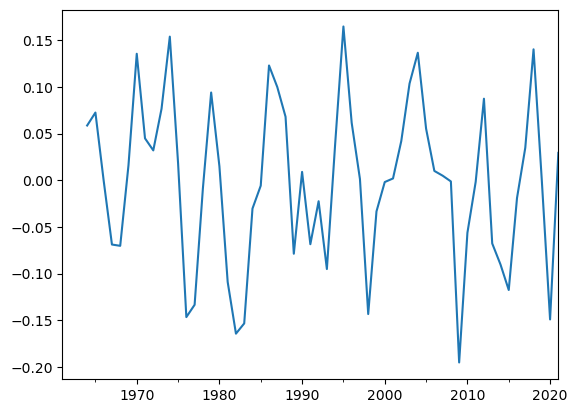

In [63]:
ts_diff1 = ts.diff(1)
ts_diff1.dropna(inplace=True)
ts_diff1.diff(3).plot(kind='line')

Differencing the time series with a period of 1 seems to eliminate the growth trend. Now we observe a cyclical component (maybe a seasonal one), which seems to have a multiplicative efect in the series. Let's check the presence of seasonality using an autocorrelation plot.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

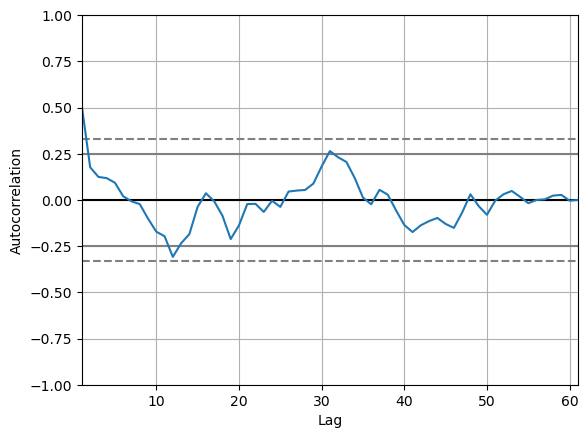

In [64]:
autocorrelation_plot(ts_diff1)

There are some noticeable peaks in the autocorrelation plot, but they lack a periodicity. Therefore, it is more likely to be due to a cycle or a trend (more likely a non-periodic cycle).

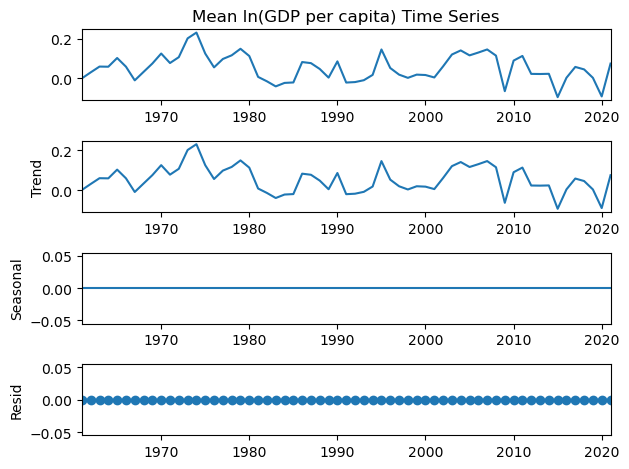

In [65]:
ts_diff1_decom = seasonal_decompose(ts_diff1, model="ad")
ts_plot = ts_diff1_decom.plot()

Now we'll check if the series is stationary. For this, we'll perform an augmented Dickey–Fuller test and a KPSS test.

In [66]:
adf_results = adfuller(ts_diff1)
adf_results

(-4.3931590002012495,
 0.0003052176478891547,
 0,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 -131.0592923775474)

In [67]:
kpss_results = kpss(ts_diff1)
kpss_results

/home/nicolas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.21354405323834166,
 0.1,
 3,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The p-value on the ADF test is lesser than 0.05, so it indicates that the series is stationary. By other side, the KPSS test can't reject the null hypothesis of non-stationarity, because its p-value is greater than 0.05. Because of that, we can assume that the series is strictly stationary, so we can now fit an ARIMA model.

### ARIMA model

The ARIMA model has 3 parameters, written as ARIMA(p,d,q), where p is the order of the autoregressive model, q is order of the moving average model, and d is the degree of differencing (we've already differenced once).

To choose p and q, we'll compute the autocorrelation function (acf) and partial autocorrelation funcion (pacf) of the series.

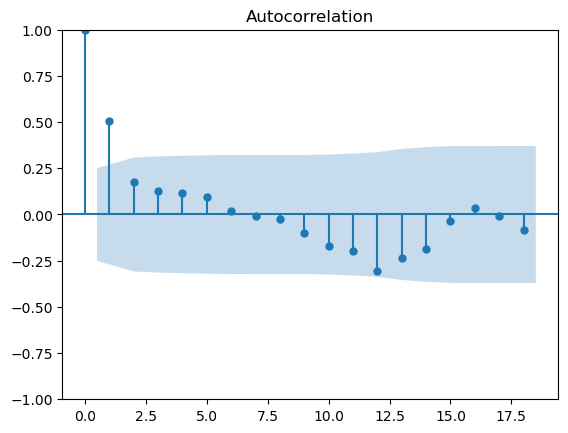

In [68]:
acf_plot = plot_acf(ts_diff1)

/home/nicolas/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


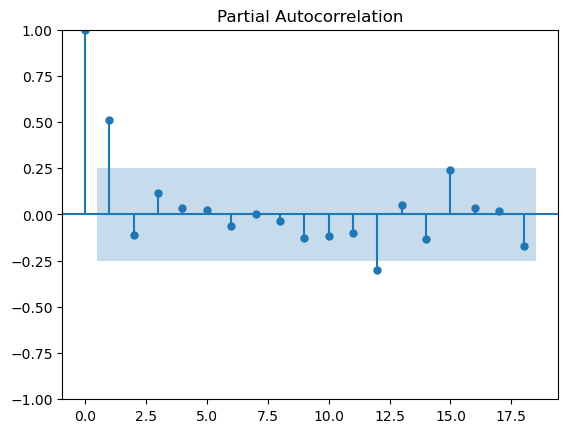

In [69]:
pacf_plot = plot_pacf(ts_diff1)

Notice that, only the first and 12th lags have a significant pacf value, so we can choose p=1 or p=12. By other side, only the first lag has a significant acf value, so we choose q=1. Since the autocorrelation of the first lag is positive, acf decays smoothly to zero and pacf decays abruptly to zero, we may just not consider the MA term, putting q=0.

We already stationarized the series with one differencing, so we can use the ARIMA model in the original series using d=1.

With this done, it's time to define our ARIMA model. Note that we have two possible values for p, so we'll define two models, and will choose the best based on the Akaike Information Criterion (AIC). Also, we'll reserve the 10 final timestamps to test the model.

In [70]:
arima1 = ARIMA(ts[:-10], order=(1,1,1), trend="t").fit()
arima1.summary()

/home/nicolas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/nicolas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/nicolas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:     Mean ln(GDP per capita) Time Series   No. Observations:                   52
Model:                                  ARIMA(1, 1, 1)   Log Likelihood                  77.021
Date:                                 Sat, 08 Jul 2023   AIC                           -146.042
Time:                                         16:22:04   BIC                           -138.314
Sample:                                     01-01-1960   HQIC                          -143.089
                                          - 01-01-2011                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0626      0.015      4.276      0.000       0.034       0.091
ar.L1          0.3651      0.280      1.303      0.192      -0.184       0.914
ma.L1          0.2620      0.279      0.938      0.348      -0.286       0.810
sigma2         0.0028      0.001      4.921      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.97   Prob(JB):                         0.93
Heteroskedasticity (H):               1.65   Skew:                            -0.08
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
arima2 = ARIMA(ts[:-10], order=(12,1,1), trend="t").fit()
arima2.summary()

/home/nicolas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/nicolas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/nicolas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:     Mean ln(GDP per capita) Time Series   No. Observations:                   52
Model:                                 ARIMA(12, 1, 1)   Log Likelihood                  80.131
Date:                                 Sat, 08 Jul 2023   AIC                           -130.262
Time:                                         16:22:04   BIC                           -101.285
Sample:                                     01-01-1960   HQIC                          -119.189
                                          - 01-01-2011                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0609      0.013      4.816      0.000       0.036       0.086
ar.L1          0.3247      2.724      0.119      0.905      -5.013       5.663
ar.L2          0.0645      1.796      0.036      0.971      -3.455       3.584
ar.L3         -0.0999      0.326     -0.306      0.759      -0.740       0.540
ar.L4          0.1076      0.332      0.324      0.746      -0.543       0.758
ar.L5          0.0669      0.387      0.173      0.863      -0.691       0.825
ar.L6         -0.2063      0.249     -0.829      0.407      -0.694       0.282
ar.L7          0.0748      0.762      0.098      0.922      -1.419       1.569
ar.L8          0.1607      0.511      0.314      0.753      -0.841       1.162
ar.L9          0.0051      0.418      0.012      0.990      -0.815       0.825
ar.L10        -0.1542      0.320     -0.481      0.630      -0.782       0.474
ar.L11        -0.0340      0.593     -0.057      0.954      -1.196       1.128
ar.L12        -0.1700      0.264     -0.645      0.519      -0.686       0.346
ma.L1          0.2715      2.790      0.097      0.922      -5.196       5.739
sigma2         0.0024      0.001      3.692      0.000       0.001       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.89   Prob(JB):                         0.55
Heteroskedasticity (H):               1.66   Skew:                            -0.30
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Note that the, in the model with p=12, almost all its parameters seem to be non-significant (high p-value). Also, it has a higher AIC than the model with p=1. Because of that, we choose the model with p=1.

In the case of the model 1, we note that the moving-average parameter is probably not significant for the model, so we'll define a new model instead, with q=0 (the acf and pacf plots gave us a hint that this was to be expected).

In [72]:
arima_model = ARIMA(ts[:-10], order=(1,1,0), trend='t').fit()
arima_model.summary()

/home/nicolas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/nicolas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/nicolas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:     Mean ln(GDP per capita) Time Series   No. Observations:                   52
Model:                                  ARIMA(1, 1, 0)   Log Likelihood                  76.424
Date:                                 Sat, 08 Jul 2023   AIC                           -146.848
Time:                                         16:22:05   BIC                           -141.052
Sample:                                     01-01-1960   HQIC                          -144.633
                                          - 01-01-2011                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0628      0.016      3.827      0.000       0.031       0.095
ar.L1          0.5444      0.119      4.586      0.000       0.312       0.777
sigma2         0.0029      0.001      5.045      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.54   Prob(JB):                         0.89
Heteroskedasticity (H):               1.53   Skew:                            -0.14
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now everything is significant, and the Q-test indicates to us that we can't discard the null hypothesis of the residuals having no autocorrelation. Furthermore, the Jarque-Bera test doesn't discard the normality of the residuals. Finally, the heteroskedasticity test doesn't let us to discard the homokedasticity of the residuals.

Let's see a plot of its forecasts.

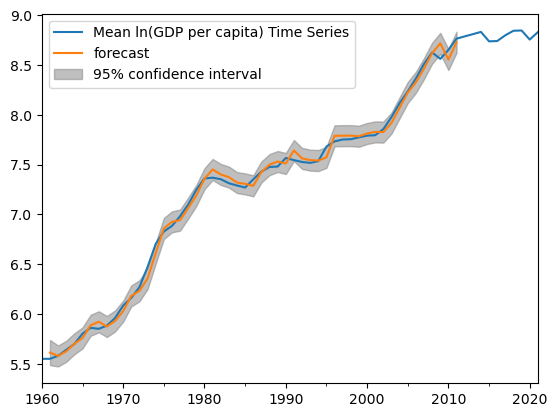

In [73]:
fig, ax = plt.subplots()
ts.plot(kind="line", ax=ax)
plot_pred = plot_predict(arima_model, start=1, end=-1, ax=ax)

In a nutshell, the model is very well-behaved. Now it's time to test if it generalizes as well as it fits the training data.

In [74]:
y_pred = pd.Series(arima_model.forecast(steps=10, dynamic=True), index=ts[-10:].index)
test_res = ts[-10:] - y_pred
mape = np.mean(np.abs(test_res)/np.abs(ts[-10:]))
print("ARIMA(0,1,1) MAPE =", mape)

ARIMA(0,1,1) MAPE = 0.04146730201785142


In [75]:
ssres = np.sum(test_res**2)
sstot = np.sum((ts[-10:]-np.mean(ts[-10:]))**2)
r2 = 1 - (ssres/sstot)
print("ARIMA(0,1,1) R2 =", r2)

ARIMA(0,1,1) R2 = -105.53172286914698


The MAPE seems prety good, but the R2 doesn't have much sense. This is because the R2 coeficient is best suited for pure linear regression. In any case, note that in terms of log-likelyhood, the ARIMA model is also by far the best model, followed by the GLS model.

Despite the goodness-to-fit of the ARIMA model, and its higher capability of generalization, there is a big con regarding to this model: the statsmodels doesn't allow us to use this model to forecast directly data from another dataset. At least not in an easy way.

For example, if we wanted to forecast the ln(GDP per capita) of a given country for the following years, we have to refit the model entirely with the new data, and then make the forecast. This problem isn't present when using the scikit-learn package, but unfortunately scikit-learn doesn't have an implementation of the ARIMA model.

So, if we don't mind refitting the model each time we change of dataset, we can use ARIMA without a doubt. But, if we wanted a forecast for each time series and want to do this efficiently, we should go with the GLS model and implement it in scikit-learn, which is what we'll be doing now.

# Implementing GLS in scikit-learn

GLS is essentially a Linear Regression with weights, where the weights are the squared of the residuals of a ordinary linear regresion. So, let's fit the usual linear regression first.

In [76]:
X = train_df.iloc[:,2:]
X_test = test_df.iloc[:,2:]
y = train_target
y_test = test_target
lin_reg = LinearRegression().fit(X, y)
print("OLS train score =", lin_reg.score(X,y))  # R2
print("OLS cross-validation score =", cross_val_score(lin_reg, X, y, cv=5).mean())
print("OLS test score =", lin_reg.score(X_test,y_test))

OLS train score = 0.7710320511611591
OLS cross-validation score = 0.7680639801962151
OLS test score = 0.7830007797061316


In [77]:
y_pred = lin_reg.predict(X)
ols_res = y - y_pred
gls_reg = LinearRegression().fit(X, y, sample_weight=ols_res**2)
print("GLS train score =", gls_reg.score(X,y))  # R2
print("GLS cross-validation score =", cross_val_score(gls_reg, X, y, cv=5).mean())
print("GLS test score =", gls_reg.score(X_test,y_test))

GLS train score = 0.7564616598822818
GLS cross-validation score = 0.7680639801962151
GLS test score = 0.769019632229439


Only in terms of estimations, both models seem prety good. The OLS model is a little bit underfitted since its cross-validation score is a bit lower than its test score. It also seems to have some difficults to generalize because its train score is higher than its cross-validation.

The GLS seems to be doing better in some sense. Despite having a lower score in general, the model compensates it by having better generalization capabilities. In fact, due to its lower training score it may need more training.

# Conclusions

In the long run, the ARIMA(1,1,0) is by far the best model. It has a very good fitting to the data and has the best generalizationcapability. Also, its residuals behave very well, so we can have an idea of what to expect on the residuals. However, because of the limitations of the statsmodels package (which is more statistical oriented), we have to refit the model each time we want to change of dataset (and we have about 160 of them).

If we don't care about the good statistical properties of the models (you should care), we can implement a GLS model using scikit-learn. Since this package is more machine-learning-oriented, its models are easier to use in a pipeline and don't have to refit them each time we want to use another dataset.

Putting aside the ARIMA(1,1,0) model, the GLS model is best for generalization. It also has a decent score, given the little amount of features (just 3) and available instances (about 1600). If we feed the model with more data, it's expected for the model to improve even further its estimation capabilities. However, we have to be aware that, because of the heteroscedasticity of the residuals, the model could become obsolet very fast, and therefore it could need to be retrained frequently.